In [ ]:
import json
import geopandas as gpd
import os
from planet import Auth
from planet import data_filter
from datetime import datetime
from planet import Session
import pandas as pd

path_to_api_key = '/explore/nobackup/people/almullen/smallsat_augmentation/code/PL_API_KEY.txt'
path_to_shapefile = '/explore/nobackup/people/almullen/smallsat_augmentation/data/rois/YKD/YKD_ABoVE_tiles_C.shp'
path_to_tile_downloads = '/explore/nobackup/people/almullen/smallsat_augmentation/data/orders/YKD'
#read the geojson as a dictionary to feed into the Planet search
#path_to_geojson = '/explore/nobackup/people/almullen/smallsat_augmentation/data/rois/YKD/YKD_ABoVE_tiles_C.shp'
#with open(path_to_geojson) as json_file:
#    geom = json.load(json_file)

#open the geojson with geopandas and plot to make sure this is the correct region   
shapefile = gpd.read_file(path_to_shapefile)
shapefile = shapefile.to_crs('EPSG:4326')


<AxesSubplot:>

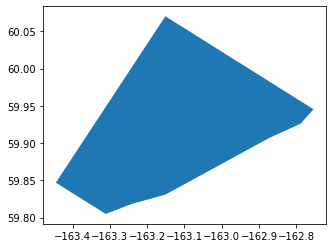

In [ ]:
#tile_id='Ch010v026' #quinhagak
tile_id= 'Ch009v024' #kwigillingok

tile = shapefile.loc[shapefile['grid_id']==tile_id]
tile.plot()

In [ ]:
#get json representation of tile
tile_json = json.loads(tile.to_json())
tile_json

{'type': 'FeatureCollection',
 'features': [{'id': '20',
   'type': 'Feature',
   'properties': {'grid_level': 'C',
    'grid_id': 'Ch009v024',
    'spatial_re': '5 meter (fine)',
    'ah': 0,
    'av': 0,
    'bh': 1,
    'bv': 4,
    'ch': 9,
    'cv': 24},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-163.4447723650566, 59.846846168427206],
      [-163.1511283966538, 60.07033941019517],
      [-162.75424945718137, 59.945460424521215],
      [-162.7888349081091, 59.92595090429171],
      [-162.87185013083922, 59.90715826568479],
      [-163.15124104679046, 59.83075835477294],
      [-163.24086236945016, 59.81839632286062],
      [-163.3109429774148, 59.80490077994321],
      [-163.4447723650566, 59.846846168427206]]]}}]}

In [13]:
#Authenticate Planet
with open(path_to_api_key) as f:
    pl_api_key = f.read(1)
    auth = Auth.from_key(pl_api_key)
    auth.store()

In [14]:
#set up API orders data filter
sfilter = data_filter.and_filter([
    data_filter.permission_filter(),
    data_filter.date_range_filter('acquired', gt=datetime(2018, 5, 1, 1), lt=datetime(2023, 11, 1, 1)),
    data_filter.geometry_filter(tile_json),
    data_filter.asset_filter(['ortho_analytic_4b_sr', 'ortho_analytic_8b_sr']),
    data_filter.range_filter('cloud_percent', lte=20),
    data_filter.string_in_filter('instrument', ['PSB.SD', 'PS2.SD'])
])

In [56]:
#Query Planet Catalog
ids = []
async def search():
    async with Session() as sess:
        cl = sess.client('data')
        items = [i async for i in cl.search(['PSScene'], sfilter, limit=0)]
        
        print('{} results'.format(len(items)))
        for item in items:
            ids.append([item['properties']['acquired'], 
                       item['id'], 
                       item['properties']['instrument'], 
                       item['properties']['cloud_percent'], 
                       item['properties']['clear_percent'], 
                       item['properties']['clear_confidence_percent'],
                       {'geometry': item['geometry'], 'properties': {}}])
        
await search()

2574 results


In [63]:
#Create dataframe with image ids and metadata
df_ids = gpd.GeoDataFrame(ids, columns = ['time', 'id', 'instrument', 'cloud_percent', 'clear_percent', 'clear_confidence_percent', 'geometry'])
df_ids['geometry'] = gpd.GeoDataFrame.from_features(df_ids['geometry'])['geometry']
df_ids = df_ids.set_geometry('geometry')
df_ids.crs='EPSG:4326'

#Filter for growing season
df_ids['time'] = pd.to_datetime(df_ids['time'])
df_ids['year'] = df_ids['time'].dt.year
df_ids['month'] = df_ids['time'].dt.month
df_ids = df_ids.loc[(df_ids['month']>=5) & (df_ids['month']<=10)]

df_ids = df_ids.sort_values(by='time')

In [64]:
df_ids

,time,id,instrument,cloud_percent,clear_percent,clear_confidence_percent,geometry,year,month
395,2019-05-10 21:50:44.501640+00:00,20190510_215044_50_1061,PS2.SD,18,7,46,"POLYGON ((-163.21589 59.87023, -163.29834 59.7...",2019,5
387,2019-05-12 21:18:02.452067+00:00,20190512_211802_45_106c,PS2.SD,16,80,79,"POLYGON ((-163.41135 59.92346, -163.32569 59.7...",2019,5
400,2019-05-13 21:55:57.744661+00:00,20190513_215557_74_105a,PS2.SD,19,79,79,"POLYGON ((-163.22944 59.83091, -163.31432 59.6...",2019,5
392,2019-05-25 21:16:41.058552+00:00,20190525_211641_05_106c,PS2.SD,2,24,46,"POLYGON ((-162.81438 60.01096, -162.73224 59.8...",2019,5
2423,2019-06-05 21:15:20.195026+00:00,20190605_211520_19_106f,PS2.SD,9,88,88,"POLYGON ((-163.49998 60.02214, -163.41321 59.8...",2019,6
...,...,...,...,...,...,...,...,...,...
4,2023-10-26 21:19:04.448906+00:00,20231026_211904_44_24a1,PSB.SD,1,97,84,"POLYGON ((-163.74067 60.26620, -163.84747 60.0...",2023,10
5,2023-10-26 21:19:06.738019+00:00,20231026_211906_73_24a1,PSB.SD,19,77,82,"POLYGON ((-163.82235 60.12660, -163.92843 59.9...",2023,10
3,2023-10-26 21:20:56.807474+00:00,20231026_212056_80_242e,PSB.SD,0,100,85,"POLYGON ((-163.23913 60.14186, -163.35157 59.9...",2023,10
8,2023-10-26 21:20:59.099556+00:00,20231026_212059_09_242e,PSB.SD,0,100,80,"POLYGON ((-163.32588 60.00209, -163.43753 59.8...",2023,10


In [67]:
from planet import order_request

tools = [order_request.harmonize_tool(target_sensor='Sentinel-2'),
           order_request.clip_tool(aoi=tile_json),
           order_request.composite_tool()
          ]

In [68]:
from planet import reporting

for t in df_ids['time'].dt.date.unique():
    
    time = str(t)
    
    if not os.path.exists(os.path.join(path_to_tile_downloads, tile_id)):
        os.mkdir(os.path.join(path_to_tile_downloads, tile_id))
        
    if not os.path.exists(os.path.join(path_to_tile_downloads, tile_id, time)):
        os.mkdir(os.path.join(path_to_tile_downloads, tile_id, time))
    
    df_t = df_ids.loc[df_ids['time'].dt.date==t]

    #composite operation places last image in list on top, so sort first by cloud percent, 
    #descending, then clear confidence percent, ascending
    df_t = df_t.sort_values(by=['cloud_percent', 'clear_confidence_percent'], ascending=[False, True])

    #build request
    request = order_request.build_request(
        name='{}_{}'.format(tile_id, time),
        products=[
            order_request.product(item_ids=df_t['id'].to_list(),
                                            product_bundle='analytic_sr_udm2',
                                            item_type='PSScene')
            ],
        tools=tools
     )

    #place the request with asynchronous function
    async def main():
        async with Session() as sess:
            cl = sess.client('orders')
            with reporting.StateBar(state='creating') as bar:
                #place order
                order = await cl.create_order(request)
                
                with open(os.path.join(path_to_tile_downloads, tile_id, time, 'order_id.txt'), 'w') as file:
                    file.write(order['id'])
                with open(os.path.join(path_to_tile_downloads, tile_id, time, 'image_ids.txt'), 'w') as file:
                    file.write(str(df_t['id'].unique()))
                    
    await main()

    

00:01 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:01 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - or